# Malaria Detection using Ensemble Method

In this project, we are trying to classify whether an image is a malaria image or not using ensemble method.

Packages used:

    1. scikit-learn 
    2. Numpy 
    3. Matplotlib 
    4. Seaborn 
    
The classification problem was solved following the steps given below:
1. Data Preprocessing and Cleaning.
2. Split data into 3 chunks using stratified sampling.
3. Handle skewness using smote algorithm in the training set.
4. Reduce dimension of images using PCA.
5. Apply ensemble method with three classifiers: adaboost algorithm, random forest classifier and svm.
6. Appropriate hyperparameter selection (n_estimators in random forest and adaboost) using accuracy vs n_estimators plot.
7. Evaluation of result on test dataset.

In [1]:
# Import packages
import os
import cv2
import time

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from collections import Counter
from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
# scikit-learn packages
from sklearn.decomposition import PCA

# Common model helpers
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Preprocessing algorithms
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Algorithms to be used in ensemble
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier

# evaluation metrics
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# data creation and visualization scripts
from src.data_creation.create_data import create_data
from src.data_visualization.plot_graphs import *

# evaluation scripts
from src.evaluation.classification_report import get_classification_report 

In [4]:
# Path to data, unique labels and size of image
datadir = 'data/uab_curated'
classes = ["0","1"]
img_size = 55

## Data Creation and PreProcessing:

At first, images were preprocessed before using the algorithms. Images were preprocessed by:
1. Converting to gray scale.
2. Applying Gaussian Blur.
3. Normalizing images to include values within [0-1] dividing every pixel by 255.
4. The images were standardized by subtracting the mean from each pixel and scaling to unit variance.
5. PCA was applied preserving 95% of variance in the data.

In [5]:
# Append all features to x
X = []
# Append target 
y = []
# Read image from data path and return appended list
data = create_data(datadir, classes, img_size)
for features,label in data:
    X.append(features)
    y.append(label)
    
img = np.array(X)
# Convert 3d image to 2d
new_img = img.reshape(img.shape[0], img.shape[1] * img.shape[2])
# Smooth the images using Gaussian Blur to reduce noise
blurred_img = cv2.GaussianBlur(new_img, (19, 19), 0)/255

100%|██████████| 1035/1035 [00:00<00:00, 1643.46it/s]


In [6]:
# Arrange positive and negative malaria images
positive_index = [index for index in range(len(y)) if y[index] == '1']
negative_index = [index for index in range(len(y)) if y[index] == '0']

positive_images = np.array([X[i] for i in positive_index])
negative_images = np.array([X[i] for i in negative_index])

<Figure size 432x288 with 0 Axes>

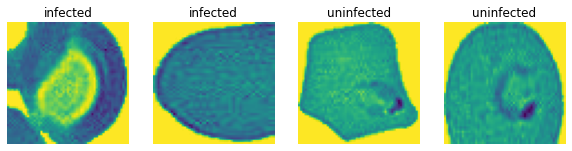

In [7]:
# Images before reshaping and applying gaussian blur
plt.figure()
fig, axes = plt.subplots(1, 4, figsize=(10,10))
ax1 = axes[0]
ax1.imshow(negative_images[0])
ax1.set_title('infected')
ax1.axis('off')
ax2 = axes[1]
ax2.imshow(negative_images[10])
ax2.set_title('infected')
ax2.axis('off')
ax3 = axes[2]
ax3.imshow(positive_images[0])
ax3.set_title('uninfected')
ax3.axis('off')
ax4 = axes[3]
ax4.imshow(positive_images[10])
ax4.set_title('uninfected')
ax4.axis('off');

The data were splitted into train, test and validation set in the ratio 70:20:10. As the dataset was imbalanced, smote oversampling algorithm was applied in the training set.

In [8]:
# Split into train, validation and test set in the ratio 70:20:10
X_train, X_test, y_train, y_test = train_test_split(blurred_img, y, test_size=0.1, shuffle=True, stratify=y, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=1)

Before oversampling:  ({'0': 1102, '1': 744})
After oversampling:  ({'0': 1102, '1': 744})


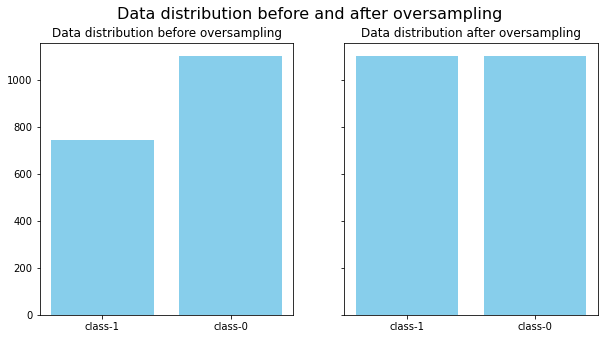

In [9]:
# Apply smote oversampling to training data
counter = Counter(y_train)
print('Before oversampling: ', str(counter).replace("Counter", ""))
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)
counter_oversample = Counter(y_train_sm)
print('After oversampling: ', str(counter).replace("Counter", ""))

f, (ax1, ax2) = plt.subplots(1,2,sharex='col', sharey='row', figsize=(10,5)) # gets the current figure and then the axes
f.suptitle('Data distribution before and after oversampling', fontsize=16)
ax1.bar(counter.keys(), counter.values(), color="skyblue", tick_label =['class-1','class-0'])
ax1.set_title('Data distribution before oversampling')

ax2.bar(counter_oversample.keys(), counter_oversample.values(), color="skyblue", tick_label =['class-1','class-0'])
ax2.set_title('Data distribution after oversampling')

plt.show()

Data distribution in test set:  ({'0': 153, '1': 104})
Data distribution in validation set:  ({'0': 276, '1': 186})


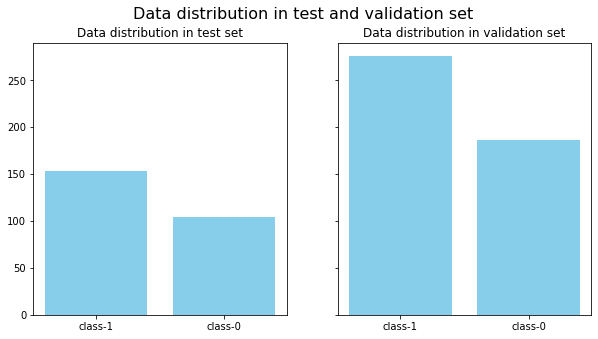

In [10]:
# Data distribution in test and validation data
count_test = Counter(y_test)
print('Data distribution in test set: ', str(count_test).replace("Counter", ""))
count_val = Counter(y_val)
print('Data distribution in validation set: ', str(count_val).replace("Counter", ""))

f, (ax1, ax2) = plt.subplots(1,2,sharex='col', sharey='row', figsize=(10,5)) # gets the current figure and then the axes
f.suptitle('Data distribution in test and validation set', fontsize=16)
ax1.bar(count_test.keys(), count_test.values(), color="skyblue", tick_label =['class-1','class-0'])
ax1.set_title('Data distribution in test set')

ax2.bar(count_val.keys(), count_val.values(), color="skyblue", tick_label =['class-1','class-0'])
ax2.set_title('Data distribution in validation set')

plt.show()

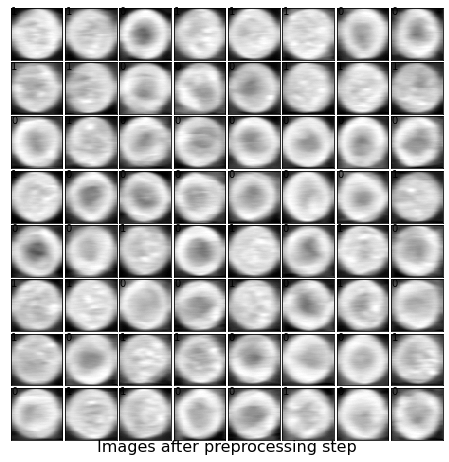

In [11]:
# Plot preprocessed images in training set
X_train_sm_re = X_train_sm.reshape(2204,55,55)
# Preprocessed training set
plot_data(X_train_sm_re, y_train_sm, "Images after preprocessing step")

In [12]:
# Standarization of data in training, test and validation set.
scaler = StandardScaler()
scaler.fit(X_train_sm)
X_train_stand = scaler.transform(X_train_sm)
X_test_stand = scaler.transform(X_test)
X_val_stand = scaler.transform(X_val)

# Apply pca to the data in training, test and validataion set.
pca = PCA(n_components=0.95)
pca.fit(X_train_stand)
pca_X_train = pca.transform(X_train_stand)
pca_X_test = pca.transform(X_test_stand)
pca_X_val = pca.transform(X_val_stand)

## Using Voting Classifier for Training

Ensemble method (Voting Classifier) was applied for training which consisted of adaboost classifier, random forest classifier and SVM. The appropriate number of estimators(n_estimator) in Adaboost Classifier and Random Forest Classifier was choosen from the accuracy vs n_estimator plot.

### Choosing appropriate n_estimators for Adaboost classifier:

In [13]:
ada_acc_train = []
ada_acc_val = []
ada_acc_test = []
ada_i_values = []

print("Adaboost Classifier - Malaria Classification")
i = 0
n_trees = [10, 50, 100, 500]
accuracy_train = 0
while i < len(n_trees):
    start_time = time.time()
    # Initialize decision tree
    clf = AdaBoostClassifier(n_estimators=n_trees[i])
    tree = clf.fit(pca_X_train, y_train_sm)
    building_time = time.time() - start_time
    train_results = tree.predict(pca_X_train)
    accuracy_train = accuracy_score(train_results, y_train_sm) * 100
    val_results = tree.predict(pca_X_val)
    accuracy_val = accuracy_score(val_results, y_val) * 100
    test_results = tree.predict(pca_X_test)
    accuracy_test = accuracy_score(test_results, y_test) * 100
    print("n_estimator = {}: ".format(n_trees[i]), end = "")
    print("accTest = {0:.2f}%, ".format(accuracy_test), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracy_train), end = "")
    print("accVal = {0:.2f}%, ".format(accuracy_val), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    ada_acc_train.append(accuracy_train)
    ada_acc_val.append(accuracy_val)
    ada_acc_test.append(accuracy_test)
    ada_i_values.append(n_trees[i])
    i += 1

Adaboost Classifier - Malaria Classification
n_estimator = 10: accTest = 94.55%, accTrain = 93.60%, accVal = 92.42%, buildTime = 0.15s
n_estimator = 50: accTest = 96.50%, accTrain = 99.50%, accVal = 97.19%, buildTime = 0.66s
n_estimator = 100: accTest = 98.05%, accTrain = 100.00%, accVal = 98.70%, buildTime = 1.18s
n_estimator = 500: accTest = 98.83%, accTrain = 100.00%, accVal = 100.00%, buildTime = 5.65s


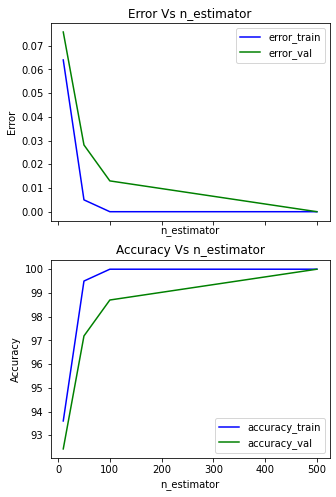

In [14]:
# plotting accuracy vs n_estimator and error vs n_estimator graph to choose the best value of n_estimator
plot_accuracy_error_graph(ada_i_values, ada_acc_train, ada_acc_val, ada_acc_test)

From the validation plot, we have choosen n_estimator=100 as the appropriate number of estimators as the error was decreasing drastically until that point.

### Choosing n_estimator for Random Forest classifier:

In [15]:
rf_acc_train = []
rf_acc_val = []
rf_acc_test = []
rf_i_values = []

print("Random Forest Classifier - Malaria Classification")

i = 0
n_trees = [3, 5, 10, 50, 100, 500]
accuracy_train = 0
accuracy_train = 0
while i < len(n_trees):
    start_time = time.time()
    # Initialize decision tree
    clf = RandomForestClassifier(n_estimators=n_trees[i])
    tree = clf.fit(pca_X_train, y_train_sm)
    building_time = time.time() - start_time
    train_results = tree.predict(pca_X_train)
    accuracy_train = accuracy_score(train_results, y_train_sm) * 100
    val_results = tree.predict(pca_X_val)
    accuracy_val = accuracy_score(val_results, y_val) * 100
    test_results = tree.predict(pca_X_test)
    accuracy_test = accuracy_score(test_results, y_test) * 100
    print("n_estimator = {}: ".format(n_trees[i]), end = "")
    print("accTest = {0:.2f}%, ".format(accuracy_test), end = "")
    print("accTrain = {0:.2f}%, ".format(accuracy_train), end = "")
    print("accVal = {0:.2f}%, ".format(accuracy_val), end = "")
    print("buildTime = {0:.2f}s".format(building_time), end = "\n")
    rf_acc_train.append(accuracy_train)
    rf_acc_val.append(accuracy_val)
    rf_acc_test.append(accuracy_test)
    rf_i_values.append(n_trees[i])
    i += 1

Random Forest Classifier - Malaria Classification
n_estimator = 3: accTest = 95.72%, accTrain = 99.41%, accVal = 95.02%, buildTime = 0.03s
n_estimator = 5: accTest = 98.44%, accTrain = 99.91%, accVal = 97.62%, buildTime = 0.05s
n_estimator = 10: accTest = 99.22%, accTrain = 100.00%, accVal = 98.05%, buildTime = 0.10s
n_estimator = 50: accTest = 100.00%, accTrain = 100.00%, accVal = 99.57%, buildTime = 0.44s
n_estimator = 100: accTest = 100.00%, accTrain = 100.00%, accVal = 99.78%, buildTime = 0.86s
n_estimator = 500: accTest = 100.00%, accTrain = 100.00%, accVal = 99.78%, buildTime = 4.16s


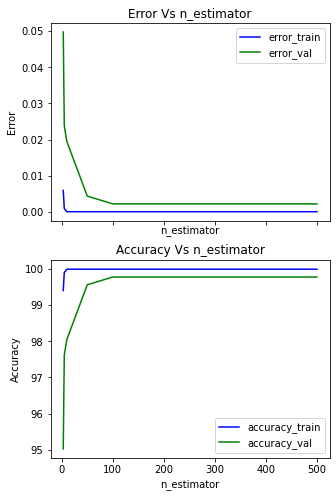

In [16]:
# plotting accuracy vs n_estimator and error vs n_estimator graph to choose the best value of n_estimator.
plot_accuracy_error_graph(rf_i_values, rf_acc_train, rf_acc_val, rf_acc_test)

From the validation plot, we have choosen n_estimator=100 as the appropriate number of estimators for random forest too as the error was decreasing drastically until that point.

### Build Voting Classifier

In [17]:
vote_est = [
    #Ensemble Methods
     ('ada', AdaBoostClassifier(n_estimators=100)),
     ('rfc', RandomForestClassifier(n_estimators=100)),
    
    #SVM
    ('svc', SVC(probability=True))
]

### Evaluation of performance of soft voting and hard voting classifiers

In [18]:
#Hard Vote or majority rules
vote_hard = VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard.fit(pca_X_train, y_train_sm)

#Soft Vote or weighted probabilities
vote_soft = VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft.fit(pca_X_train, y_train_sm)

VotingClassifier(estimators=[('ada', AdaBoostClassifier(n_estimators=100)),
                             ('rfc', RandomForestClassifier()),
                             ('svc', SVC(probability=True))],
                 voting='soft')

In [19]:
# comparison of cross validation score of hard and soft voting classifiers
cv_hard = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(vote_hard, pca_X_train, y_train_sm, scoring='accuracy', cv=cv_hard)
# report performance
print('Accuracy(hard voting classifier): %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

cv_soft = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(vote_soft, pca_X_train, y_train_sm, scoring='accuracy', cv=cv_soft)
# report performance
print('Accuracy(soft voting classifier): %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy(hard voting classifier): 0.998 (0.004)
Accuracy(soft voting classifier): 1.000 (0.001)


In [20]:
# comparison of accuracy and f1-score of soft and hard voting classifier on validation set
predictions_val_hard = vote_hard.predict(pca_X_val)
predictions_val_soft = vote_soft.predict(pca_X_val)

# report performance on validation set
print('Accuracy(hard): {0:.3f}'.format(accuracy_score(y_val, predictions_val_hard)))
print('F1 Score(hard): {0:.3f}'.format(f1_score(y_val, predictions_val_hard, pos_label='1')))

print('Accuracy(soft): {0:.3f}'.format(accuracy_score(y_val, predictions_val_soft)))
print('F1 Score(soft): {0:.3f}'.format(f1_score(y_val, predictions_val_soft, pos_label='1')))

Accuracy(hard): 0.998
F1 Score(hard): 0.997
Accuracy(soft): 1.000
F1 Score(soft): 1.000


As the cross validation score of soft voting classifier was higher than the hard voting classifier, we chose soft voting classifier as our model.

### Performance of train and validation set on the selected model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1102
           1       1.00      1.00      1.00      1102

    accuracy                           1.00      2204
   macro avg       1.00      1.00      1.00      2204
weighted avg       1.00      1.00      1.00      2204



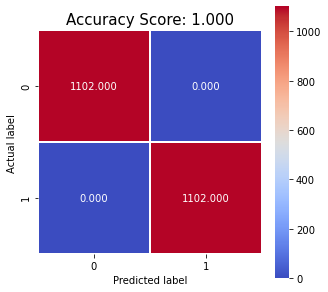

In [21]:
# get performance of training dataset
predictions_train = vote_soft.predict(pca_X_train)
get_classification_report(y_train_sm, predictions_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       276
           1       1.00      1.00      1.00       186

    accuracy                           1.00       462
   macro avg       1.00      1.00      1.00       462
weighted avg       1.00      1.00      1.00       462



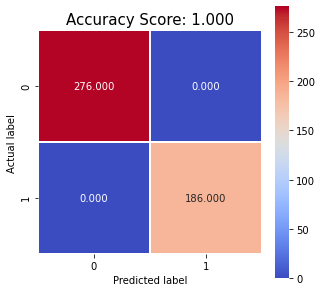

In [22]:
# get performance of validation dataset
predictions_val = vote_soft.predict(pca_X_val)
get_classification_report(y_val, predictions_val)

Therefore, the selected model performs quite well on both training and validation dataset.

As training dataset was balanced after applying smote oversampling algorithm, roc-auc curve was plotted for training dataset and precision-recall curve for validation set which was imbalanced.

Train: ROC AUC=1.000


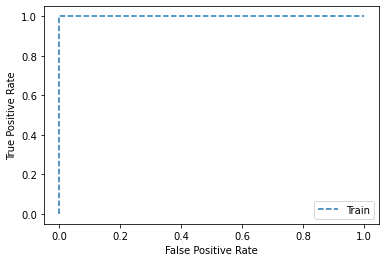

In [23]:
# plot roc_auc curve for training dataset
plot_roc_auc_curve(np.array(y_train_sm).astype(np.int), predictions_train.astype(np.int))

From the roc-auc curve, we can see that the true positive rate is 1 when the false positive rate is 0. 

Test: f1=1.000 auc=1.000


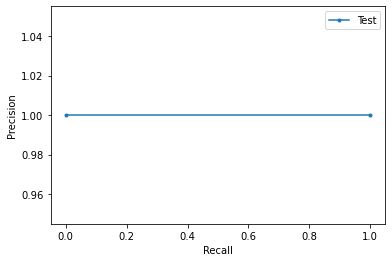

In [24]:
# plot precision recall curve for validation set
plot_precision_recall_curve(np.array(y_val).astype(np.int), predictions_val.astype(np.int))

From the precision-recall curve, it can be seen that there is a precision of 1 when recall in 1 in the validation set.

## Evaluation of test dataset on the choosen model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       104

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257



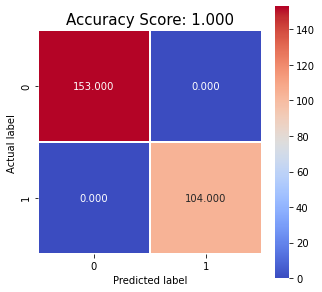

In [25]:
# get performance of test dataset on the selected model
predictions_test = vote_soft.predict(pca_X_test)
get_classification_report(y_test, predictions_test)

Test: f1=1.000 auc=1.000


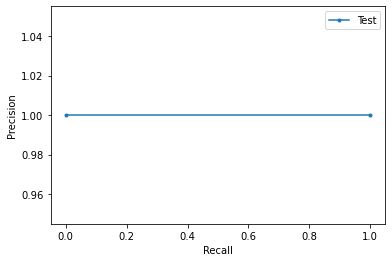

In [26]:
# plotting precision-recall curve for test dataset which is imbalanced 
plot_precision_recall_curve(np.array(y_test).astype(np.int), predictions_test.astype(np.int))

Therfore, the test dataset performs quite well on the selected model and achieves accuracy of 100%. From the precision-recall curve, we see that there is a precision of 1 when recall in 1.